# $$
\text{Optimisation}
$$

### Objectifs :

- Implémenter la méthode des moindres carrés pour les systèmes linéaires et pour l'approximation polynomiale ;
- Résoudre des problèmes d'optimisation sans contrainte grâce au module `optimize` de scipy, puis à la méthode du gradient à pas fixe ;
- Implémenter la méthode du gradient conjugué pour des fonctionnelles quadratiques ;
- Implémenter la méthode de Newton-Lagrange pour des problèmes d'optimisation avec contraintes d'égalité.

## I. Méthode des moindres carrés

### 1. Méthode des moindres carrés pour les systèmes linéaires

Soit $A\in \mathcal{M}_{m, n}(\mathbb{R})$ et $b \in \mathbb{R}^m$. Le problème des moindres carrés consiste à déterminer une solution $\bar{x}$ du problème de minimisation :
$$
\| A \bar{x} - b \| = \min_{x \in \mathbb{R}^n} \| Ax - b\|,
$$
où $\| \cdot \|$ désigne la norme euclidienne de $\mathbb{R}^n$. Ce problème admet toujours une solution, qui est unique si $A$ est injective. Un vecteur $\bar{x}$ est de plus solution si et seulement s'il satisfait le système linéaire
$$
A^T A \bar{x} = A^T b.
$$
La fonction `sol_mc(A,b)`suivante calcule une solution $\bar{x}$ du problème des moindres carrés en résolvant ce système :

In [1]:
import numpy as np
def sol_mc(A,b):
    return(np.linalg.solve(np.transpose(A)@A,np.transpose(A)@b))
# Test de la fonction sol_mc
A1=np.array([[1,2],[3,4],[5,6],[7,8]])
b1=np.array([[1],[3],[2],[0]])
barx1=sol_mc(A1,b1)
print('x =',barx1,'\n')
print(np.transpose(A1)@A1@barx1-np.transpose(A1)@b1)

x = [[-2.5]
 [ 2.3]] 

[[-7.10542736e-15]
 [ 2.13162821e-14]]


La routine `numpy.linalg.lstsq` renvoie une solution du problème des moindres carrés. Lorsque $A$ n'est pas injective, il existe une infinité de solutions, et la première composante de la fonction `numpy.linalg.lstsq` renvoie la solution qui a la plus petite norme euclidienne :

In [2]:
A2=np.array([[1,2,3],[3,4,7],[5,6,11],[7,8,15]])
b2=np.array([[1],[0],[2],[6]])
barx2=np.linalg.lstsq(A2,b2,1e-15)[0]
print('x =',barx2,'\n')
print(np.transpose(A2)@A2@barx2-np.transpose(A2)@b2)

x = [[ 1.71666667]
 [-1.43333333]
 [ 0.28333333]] 

[[6.39488462e-14]
 [9.94759830e-14]
 [1.42108547e-13]]


### 2. Méthode des moindres carrés pour l'approximation polynomiale

Considérons une fonction $f : \mathbb{R} \to \mathbb{R}$ et des points $x_0 < \ldots < x_{n-1}$, et notons $y = (f(x_0), \ldots, f(x_{n-1}))^T$, le vecteur des valeurs de $f$ en ces points. Étant donné un degré $d \geq 0$, le problème des moindres carrés pour l'approximation polynomiale consiste à déterminer un polynôme $\bar{P}$ solution du problème de minimisation
$$
\sum_{i = 0}^{n-1} |y_i - \bar{P}(x_i)|^2 = \min_{P \in \mathbb{R}_d(X)} \sum_{i = 0}^n |y_i - P(x_i)|^2.
$$
En notant
$$
\bar{P}(X) = \sum_{j=0}^d \bar{a}_j X^j.
$$
et en introduisant le vecteur $\bar{a} = (\bar{a}_0, \ldots, \bar{a}_d)^T$, nous observons que ce problème revient à résoudre le problème des moindres carrés
$$
\| y - M \bar{a} \|^2 = \min_{a \in \mathbb{R}^{d+1}} \| y - M a \|^2,
$$
où la matrice $M$ est égale à
$$
M = \begin{pmatrix} 1 & x_0 & x_0^2 & \ldots & x_0^d \\ 
1 & x_1 & x_1^2 & \ldots & x_1^d \\ 
\vdots & \vdots & \vdots & \vdots & \vdots\\
1 & x_n & x_n^2 & \ldots & x_n^d \\ \end{pmatrix}.
$$
Pour $d \leq n$, la solution de ce second problème est donnée par l'unique solution du système linéaire
$$
M^T M \bar{a} = M^T y.
$$

La fonction `poly_mc(x,y,d)` ci-dessous calcule la solution $\bar{a}$ de ce système, puis renvoie le polynôme $\bar{P}$ associé. Elle est basée sur la fonction auxiliaire `poly_mc_M(x,d)` qui calcule la matrice $M$ :

In [3]:
def poly_mc_M(x,d):
    n=len(x)-1
    M=np.zeros([n+1,d+1])
    for i in range(n+1):     # création de la matrice M associée au vecteur x
        for j in range(d+1):
            M[i,j]=x[i]**j
    return(M)
# Test de la fonctionpoly_mc_M pour les points (1, 2, 3, 4)
x1=np.arange(1,5,1)
print(poly_mc_M(x1,2),'\n')
print(poly_mc_M(x1,3),'\n')

[[ 1.  1.  1.]
 [ 1.  2.  4.]
 [ 1.  3.  9.]
 [ 1.  4. 16.]] 

[[ 1.  1.  1.  1.]
 [ 1.  2.  4.  8.]
 [ 1.  3.  9. 27.]
 [ 1.  4. 16. 64.]] 



La fonction`poly_mc(x,y,d)`est alors définie de la façon suivante :

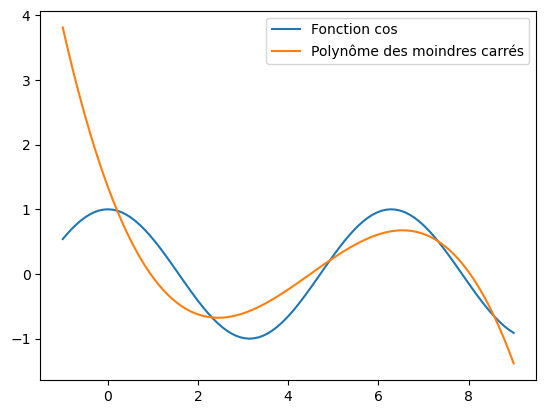

In [4]:
def poly_mc(x,y,d):
    M=poly_mc_M(x,d)
    abar=np.linalg.solve(np.transpose(M)@M,np.transpose(M)@np.transpose(y))
    def poly_mc_aux(x):
        z=np.array([abar[i]*(x**i) for i in range(d+1)])
        return(np.sum(z))
    return poly_mc_aux
# Test de la fonction poly_mc avec la fonction cosinus et pour les points (0, 1, 2, 3, 4, 5, 6, 7, 8)
import matplotlib.pyplot as plt
x2=np.arange(0,9,1)
y2=np.cos(x2)
x2bis=np.linspace(-1,9,100)
y2bis=np.cos(x2bis)
p2=poly_mc(x2,y2,3)
y2mc=np.array([p2(x2bis[i]) for i in range(100)])
plt.plot(x2bis,y2bis,label="Fonction cos")
plt.plot(x2bis,y2mc,label="Polynôme des moindres carrés")
plt.legend()
plt.show()

La routine `numpy.polynomial.polynomial.polyfit(x,y,d)` renvoie, pour des points $x = (x_0, \ldots, x_n)$ et des valeurs $y = (y_0, \ldots, y_n) = (f(x_1), \ldots, f(x_n))$ les coefficients $(\bar{a}_0, \ldots, \bar{a}_d)$ du polynôme $\bar{P}$ obtenu par la méthode des moindres carrés :

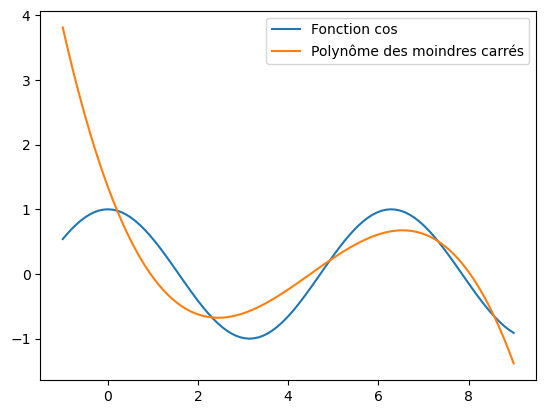

In [5]:
import numpy.polynomial as npp
import numpy.polynomial.polynomial as nppp
x3=np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])
y3=np.cos(x3)
p3=npp.polynomial.polyfit(x3,y3,3)
y3mc=np.array([nppp.polyval(x2bis[i],p3) for i in range(100)])
plt.plot(x2bis,y2bis,label="Fonction cos")
plt.plot(x2bis,y3mc,label="Polynôme des moindres carrés")
plt.legend()
plt.show()

## II. Optimisation sans contrainte

### 1. Utilisation du module scipy.optimize

La routine `minimize` du module scipy.optimize permet de minimiser une fonctionnelle. Elle implémente différentes méthodes suivant les arguments mentionnés. A minima, il faut lui indiquer la fonction à minimiser et un point d'initialisation $x_0$. Afin de mieux comprendre le fonctionnement de cette routine, introduisons la fonction
$$
\forall (x, y) \in \mathbb{R}^2, g(x, y) = 1 - x^2 +y + x^4 + y^6,
$$
et considérons le problème de minimisation
$$
g(\bar{x}, \bar{y}) = \min_{(x, y) \in \mathbb{R}^2} g(x, y).
$$
Afin de résoudre ce problème, nous commençons par représenter graphiquement cette fonction, puis tâchons de déterminer grossièrement la position d'un possible minimiseur à l'aide de la routine`pyplot.pcolormesh` :

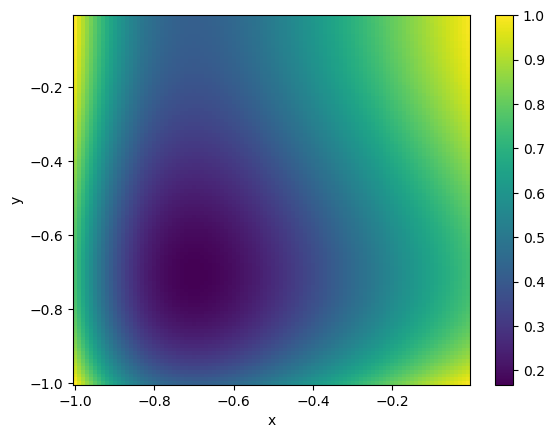

In [6]:
x4 = np.arange(-1,0,0.01)
y4 = np.arange(-1,0,0.01)
(X4,Y4) = np.meshgrid(x4, y4) # crée une grille de points
n4=len(x4)
def func4(x,y):
    return(1-x**2+y+x**4+y**6)
Z4=np.zeros([n4,n4])
for i in range(n4):
    for j in range(n4):
        Z4[i,j]= func4(x4[i],y4[j])
plt.pcolormesh(X4, Y4, Z4) 
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.show()

Après avoir observé que $(-0.6,-0.6)$ est un possible minimiseur, nous déterminons numériquement un minimiseur en prenant un point initial proche de ce point :

In [7]:
import scipy.optimize as opt
def func4(x):
    return(1-x[0]**2+x[1]+x[0]**4+x[1]**6)
print(opt.minimize(func4,np.array([-0.6,-0.6])))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.16764406769096052
        x: [-7.071e-01 -6.988e-01]
      nit: 6
      jac: [-2.179e-06 -6.892e-08]
 hess_inv: [[ 2.740e-01  4.289e-04]
            [ 4.289e-04  1.398e-01]]
     nfev: 27
     njev: 9


Une valeur numérique du minimiseur est donc donnée par le couple $(-0.7071, -0.6988)$. Pour plus de détails quant aux autres informations, nous renvoyons à l'aide de la fonction `minimize` :

In [8]:
help('scipy.optimize.minimize')

Help on function minimize in scipy.optimize:

scipy.optimize.minimize = minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    Minimization of scalar function of one or more variables.

    Parameters
    ----------
    fun : callable
        The objective function to be minimized.

            ``fun(x, *args) -> float``

        where ``x`` is a 1-D array with shape (n,) and ``args``
        is a tuple of the fixed parameters needed to completely
        specify the function.
    x0 : ndarray, shape (n,)
        Initial guess. Array of real elements of size (n,),
        where ``n`` is the number of independent variables.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (`fun`, `jac` and `hess` functions).
    method : str or callable, optional
        Type of solver.  Should be one of

            - 'Nelder-Mead' :ref:`(see here) <op

### 2. Méthode du gradient à pas fixe

Considérons une fonction $f\in \mathcal{C}^1(\mathbb{R}^n, \mathbb{R})$ et intéressons-nous au problème de minimisation
$$
f(\bar{x}) = \min_{x \in \mathbb{R}^n} f(x).
$$
Étant donné un pas fixé $\rho > 0$ et un point initial $x_0\in \mathbb R^n$, la méthode du gradient à pas fixe consiste à calculer $x_1$ suivant la formule
$$
x_1 = x_0 - \rho \nabla f(x_0),
$$
puis à itérer cette procédure
$$
\forall k \geq 1, \, x_{k+1} = x_k - \rho J\nabla F(x_k).
$$

Sous des hypothèses à préciser, la suite $(x_k)_{k \geq 0}$ ainsi déterminée converge vers un minimum local $\bar{x}$ de $f$. Étant donné un seuil d'erreur $\varepsilon_0 > 0$, nous pouvons alors arrêter l'algorithme lorsque $$
|x_k - x_{k-1}| \leq \varepsilon_0.
$$

Il se peut néanmoins que la suite $(x_k)_{k \geq 0}$ ne soit pas convergente. Nous pouvons donc fixer une limite maximale d'itérations $N \geq 0$ et décider d'arrêter l'algorithme lorsque $k \geq N$. La fonction `grad_pasfixe(Df,rho,x0,e0,N)` suivante renvoie le résultat de la méthode de descente du gradient à pas fixe via cette procédure :

In [9]:
def grad_pasfixe(Df,rho,x0,e0,N):
    x=x0
    y=x0
    e=2*e0
    n=0
    while n<N and e>e0:
        y=x-rho*Df(x)
        e=np.linalg.norm(y-x)
        x=y
        n=n+1
    if n<N:
        return(x)
    else:
        return("L'algorithme n'a pas convergé.")

Afin de tester la fonction `grad_pasfixe`, nous l'appliquons à la fonction
$$
\forall (x, y) \in \mathbb{R}^2, \, h(x,y)=x^4+y^6-xy.
$$
Nous commençons par représenter graphiquement cette fonction pour déterminer une valeur initiale adaptée pour l'algorithme du gradient à pas fixe :

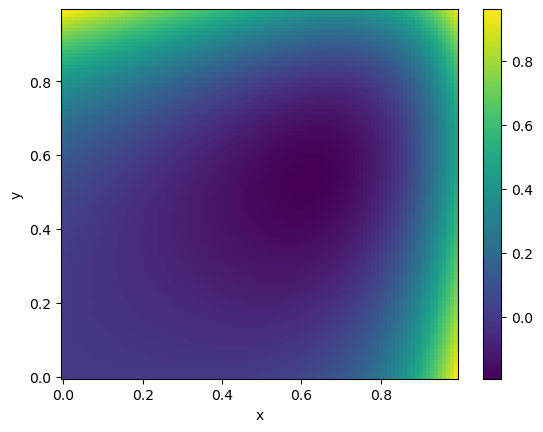

In [10]:
x5 = np.arange(0,1,0.01)
y5 = np.arange(0,1,0.01)
(X5,Y5) = np.meshgrid(x5, y5) # crée une grille de points
n5=len(x5)
def func3(x,y):
    return(x**4+y**6-x*y)
Z5=np.zeros([n5,n5])
for i in range(n5):
    for j in range(n5):
        Z5[i,j]= func3(x5[i],y5[j])
plt.pcolormesh(X5, Y5, Z5) 
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar()
plt.show()

Étant donné ce tracé, nous fixons comme point initial le point $(0.6,0.6)$ :

In [11]:
def Df4(x):
    return(np.array([4*((x[0])**3)-x[1],6*((x[1])**5)-x[0]]))
x0=np.array([1,1])
print('[x, y] =',grad_pasfixe(Df4,0.1,x0,0.01,10),'\n')

[x, y] = [0.54321902 0.61345549] 



## III. Méthode du gradient conjugué

Soit $A \in \mathcal{S}_n^{++}(\mathbb{R})$ une matrice symétrique définie positive et $b \in \mathbb{R}^n$. Considérons la fonctionnelle
$$
\forall x \in \mathbb{R}^n, \, Q(x) =\frac{1}{2} x^T A x - b^T x,
$$
et le problème de minimisation associé
$$
Q(\bar{x}) = \min_{x \in \mathbb{R}^n} Q(x).
$$
Ce problème admet une unique solution $\bar{x}$ qui est caractérisée par l'équation
$$
A \bar{x} = b.
$$
Nous observons que
$$
\forall x \in \mathbb{R}^n, \, \nabla Q(x) = A x - b,
$$
de sorte que cette équation s'écrit aussi
$$
\nabla Q(x) = 0.
$$
La méthode du gradient à pas conjugué permet de résoudre le système linéaire précédent via la résolution du problème de minimisation associée.

Il s'agit d'une méthode de gradient à pas optimal. Elle repose sur l'introduction de points $(x_k)_{k \geq 0}$, de directions de descente $(w_k)_{k \geq 0}$ et de pas $(\rho_k)_{k \geq 1}$ reliés par la formule
$$
\forall k \geq 0, \, x_{k+1} = x_k + \rho_{k+1} w_k.
$$
Le pas $\rho_{k+1}$ est celui qui minimise $Q$ au point $x_k$ dans la direction de descente $w_k$
$$
Q \big( x_k + \rho_{k+1} w_k \big) = \min_{\rho > 0} Q \big( x_k + \rho w_k \big).
$$
La particularité de l'algorithme tient au fait que les directions de descente sont choisies de façon à être toutes orthogonales (par rapport au produit scalaire associé à la matrice $A$) à chaque itération
$$
\forall k < k', \, w_k^T A w_{k'} = 0.
$$
En pratique, l'algorithme est initialisé par le choix d'un point $x_0$. À l'étape $k$ où le point $x_k$ est déterminé, le gradient $u_k$ de la fonction $Q$ en $x_k$ vaut
$$
u_k = A x_k - b.
$$
Si $u_k = 0$, alors $x_k$ est la solution recherchée et l'algorithme s'arrête. Sinon, la direction de descente $w_k$ est choisie sous la forme
$$
w_k = - u_k + \sum_0^{k-1} \alpha_{k,i} w_i,
$$
où les coefficients $\alpha_{k,i}$ sont déterminés de sorte que $w_k A^T w_{i}=0$ pour $0 \leq i \leq k-1$. Il est possible de vérifier qu'alors
$$
\forall 0 \leq i \leq k-2, \alpha_{k,i} = 0.
$$
Cette affirmation provient du fait que, par construction,
$$
A w_k = \frac{1}{\rho_k} \big( u_{k+1} - u_k \big), \quad u_k \in \text{Vect}(w_0, \ldots, w_k), \quad \text{ et } \quad\forall i < k, \, u_k^T w_i = 0.
$$
Nous obtenons que 
$$
w_k = - u_k + \alpha_k w_{k-1},
$$
puis sous la condition $w_k^T A w_{k-1} = 0$, que
$$
\alpha_k = \frac{u_k^T w_{k-1}}{w_{k-1}^T A w_{k-1}}.
$$
Nous posons alors $x_{k+1} = x_k + \rho_{k+1} w_k$, où le pas optimal $\rho_{k+1}$ est donné par la formule
$$
\rho_{k+1} = \frac{b^T w_k - x_k^T A w_k}{w_k^T A w_k}= - \frac{w_k^T u_k}{w_k^T Aw_k}.
$$

Comme les directions $w_k$ sont deux à deux orthogonales, elles sont forcément nulles lorsque $k > n$. Par définition de cet algorithme, cette propriété assure qu'il converge en au plus $n$ itérations vers la solution recherchée.

En pratique, il est nécessaire de tenir compte des erreurs numériques. Sachant que $\nabla Q(x) = 0$ pour la solution recherchée, nous choisissons la quantité $\| \nabla Q(x_k)\|$ comme erreur dans l'algorithme. Celui-ci s'arrête donc dès que cette erreur sera plus petite qu'un seuil $\varepsilon > 0$ choisi au prealable. C'est cette approche que code la fonction `grad_conj(A,b,x0,K,e)` suivante :

In [12]:
def grad_conj(A,b,x0,K,e):
    k=0
    x=np.copy(x0) # utilisation de np.copy() pour obtenir une copie distincte de x0
    u=A@x-b   # calcul du gradient de la fonction Q au point x0
    w=-np.copy(u)    # calcul de la direction de descente wk (pour k=0)
    while k<K and np.linalg.norm(u)>e:
        rho=-np.sum(u*w)/(np.sum((A@w)*w))
        x=x+rho*w
        u=A@x-b # calcul du gradient de la fonction Q au point xk
        alpha=np.sum(u*(A@w))/(np.sum((A@w)*w))
        w=u+alpha*w # calcul de la direction de descente wk
        k=k+1
    if k<K:
        return(x)
    else:
        return("l'algorithme n'a pas converge")
# Test de la fonction grad_conj
A6=np.array([[10,1,3,-1],[1,10,1,1],[3,1,10,1],[-1,1,1,10]])
b6=np.array([[1],[2],[3],[4]])
x0_1=np.array([[0],[0],[0],[0]])
x6=grad_conj(A6,b6,x0_1,10,0.001)
print('x =',x6,'\n')
print(A6@x6-b6)

x = [[0.0532046 ]
 [0.13447043]
 [0.233736  ]
 [0.36845277]] 

[[-7.28328608e-04]
 [ 9.76515288e-05]
 [-1.02998311e-04]
 [-4.70435961e-04]]


## IV. Optimisation sous contraintes d'égalités : la méthode de Lagrange-Newton

Soit $f \in \mathcal{C}^1(\mathbb{R}^n, \mathbb{R})$ et $g = (g_0, \ldots, g_{m-1}) \in \mathcal{C}^1(\mathbb{R}^n, \mathbb{R}^m)$. Rappelons que, pour toute solution $\bar{x}$ du problème de minimisation sous contraintes d'égalités
$$
f(\bar{x}) = \min_{x \in \mathbb{R}^n \text{ t.q. } g(x) = (0, \ldots, 0)} \, f(x),
$$
telle que la matrice jacobienne $J(g)(\bar{x})$ est de rang $m$, il existe des multiplicateurs de Lagrange $(\bar{q}_0, \ldots,\bar{q}_{m-1}) \in \mathbb{R}^m$ tels que
$$
\nabla f(\bar{x}) + \sum_{i=0}^{m-1} \bar{q}_i \nabla g_i(\bar{x}) = 0.
$$
Cette égalité s'écrit aussi
$$
\nabla_x L(\bar{x}, \bar{q}) = 0,
$$
où
$$
\forall (x, q) \in \mathbb{R}^n \times \mathbb{R}^m, \, L(x,q) = f(x) + \sum_{i=0}^{m-1} q_i g_i(x),
$$
est le Lagrangien de ce problème de minimisation.

Étant donnée une solution $\bar{x}$ de ce problème de minimisation pour laquelle $J(g)(\bar{x})$ est de rang $m$, il existe donc un vecteur $\bar{q} \in \mathbb{R}^m$ tel que $\bar{y} = (\bar{x}, \bar{q})$ est une solution de l'équation
$$
F(\bar{y}) = 0,
$$
où
$$
\forall (x, q) \in \mathbb{R}^n \times \mathbb{R}^m, \, F(x, q) = \big( \nabla f(x) + \sum_{i=0}^{m-1} q_i \nabla g_i(x), g_0(x), \ldots, g_{m-1}(x) \big).
$$
La méthode de Lagrange-Newton pour résoudre le problème de minimisation considéré consiste à déterminer une solution $\bar{y}$ de cette équation par la méthode de Newton-Raphson. Comme cette équation peut avoir des solutions qui ne sont pas des solutions du problème de minimisation (par exemple des maxima de la fonction $f$ sous la même contrainte $g = 0$), il s'agit de vérifier que le point $\bar{x}$ ainsi déterminé est bien un minimiseur.

Voici les différentes étapes d'un code qui met en pratique cette méthode. Nouc commençons par coder la fonction `F(Jf,g,n,m)` qui prend en entrée les fonctions $J f$, $g$, et $J g$, ainsi que les entiers $n$ et $m$, et renvoie la fonction $F$ ci-dessus :

In [13]:
def F(Jf,g,Jg,n,m):
    def F_aux(y):
        x=y[0:n]
        q=y[n:n+m]
        z=np.zeros([n+m])   # introduction du vecteur z retourné par la fonction F
        z[0:n]=Jf(x)   
        for i in range(m):
            z[0:n]=z[0:n]+q[i]*Jg(x)[i]
        z[n:n+m]=g(x)
        return(z)
    return(F_aux)
# Test de la fonction F sur les fonctions f(x)=x_0^2-x_1^3+x_0x_1 et g(x)=x_0^2+x_1^2-1
def f1(x):
    return np.array([x[0]**2-x[1]**3+x[0]*x[1]])
def Jf1(x):
    return(np.array([2*x[0]+x[1],-3*((x[1])**2)+x[0]]))
def g1(x):
    return(np.array([(x[0])**2+(x[1])**2-1])) # forme vectorielle de g pour compatibilité avec le code de F
def Jg1(x):  
    return(np.array([[2*x[0],2*x[1]]])) # forme vectorielle de Jg pour compatibilité avec les codes de F et de JF ci-dessous
F1=F(Jf1,g1,Jg1,2,1)
print('F1(0,0,0) =',F1(np.array([0,0,0])),'\n')
print('F1(1,1,1) =',F1(np.array([1,1,1])),'\n')

F1(0,0,0) = [ 0.  0. -1.] 

F1(1,1,1) = [5. 0. 1.] 



L'algorithme de Newton-Raphson nécessite de connaître la matrice jacobienne $J F$ de $F$ qui est donnée par l'expression
$$
JF(x,q)= \begin{pmatrix} \partial_{x_0 x_0} f + \sum_{l=0}^{m-1} q_l \partial_{x_0 x_0}g_l & \ldots & \partial_{x_0 x_{n-1}} f + \sum_{l=0}^{m-1} q_l \partial_{x_0 x_{n-1}} g_l & \partial_{x_0} g_0 & \ldots & \partial_{x_0} g_{m-1} \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
\partial_{x_0 x_{n-1}} f + \sum_{l=0}^{m-1} q_l \partial_{x_0 x_{n-1}} g_l & \ldots & \partial_{x_{n-1} x_{n-1}} f +\sum_{l=0}^{m-1} q_l \partial_{x_{n-1} x_{n-1}} g_l & \partial_{x_{n-1}} g_0 & \ldots & \partial_{x_{n-1}}g_{m-1} \\
\partial_{x_0} g_0 & \ldots & \partial_{x_{n-1}} g_0 & 0 & \ldots & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
\partial_{x_0} g_{m-1} & \ldots & \partial_{x_{n-1}} g_{m-1} & 0 & \ldots & 0 \\
\end{pmatrix}.
$$
Cette expression s'écrit sous la forme
$$
JF(x, q) = \begin{pmatrix} M_1 & M_3 \\ M_2 & 0 \end{pmatrix},
$$
où
$$
M_1 = H f + \sum_{i=0}^{m-1} q_i H g_i, \quad M_2 = J g, \quad \text{ et } \quad M_3 = (J g)^T.
$$
Les notations $H f$ et $H g_i$ désignent ici les matrices hessiennes des fonctions $f$ et $g_i$. La fonction `JF(Hf,Jg,Hg,n,m)` suivante prend en entrée les fonctions $H f$, $J g$ et $H g$, ainsi que les entiers $n$, et $m$, et renvoie la fonction $J F$ :

In [14]:
def JF(Hf,Jg,Hg,n,m):
    def JF_aux(y):
        x=y[0:n]
        q=y[n:n+m]
        M=np.zeros([n+m,n+m])  # introduction de la matrice M retournée par la fonction JF
        M[0:n,0:n]=Hf(x)
        for i in range(m):
            M[0:n,0:n]=M[0:n,0:n]+q[i]*Hg(x)[i]
        M[n:n+m,0:n]=Jg(x)
        M[0:n,n:n+m]=np.transpose(Jg(x))
        return(M)
    return(JF_aux)
# Test de la fonction J F sur les fonctions f(x)=x_0^2-x_1^3+x_0x_1 et g(x)=x_0^2+x_1^2-1
def Hf1(x):
    return(np.array([[2,1],[1,-6*x[1]]]))
def Hg1(x):
    return(np.array([[[2,0],[0,2]]]))
JF1=JF(Hf1,Jg1,Hg1,2,1)
print('JF1(0,0,0) =',JF1(np.array([0,0,0])),'\n')
print('JF1(1,1,1) =',JF1(np.array([1,1,1])),'\n')

JF1(0,0,0) = [[2. 1. 0.]
 [1. 0. 0.]
 [0. 0. 0.]] 

JF1(1,1,1) = [[ 4.  1.  2.]
 [ 1. -4.  2.]
 [ 2.  2.  0.]] 



Nous introduisons ensuite la fonction `Newton_Raphson` qui code l'algorithme de Newton-Raphson pour la résolution des systèmes non linéaires :

In [15]:
def Newton_Raphson(Func,JFunc,y0,eps,N):
    e=2*eps
    n=0
    y=y0
    while e>eps and n<N:
        y=y-np.linalg.solve(JFunc(y),Func(y))
        e=np.linalg.norm(Func(y))
        n=n+1
    if n<N:
        return(y)
        print(y)
    else:
        return("L'algorithme n'a pas convergé.")
# Test de la fonction Newton_Raphson pour la fonction F1
print('z =',Newton_Raphson(F1,JF1,np.array([-1,-1,-1]),0.0001,10),'\n')

z = [-0.66215608 -0.74936829 -1.56585468] 



Nous codons enfin la fonction `Lag_New(Jf,Hf,g,Jg,Hg,x0,q0,eps,N)` suivante qui implémente l'algorithme de Lagrange-Newton à l'aide des fonctions `F(Jf,g,Jg,n,m)`, `JF(Hf,Jg,Hg,n,m)` et `Newton_Raphson(Func,JFunc,x0,eps,N)`:

In [16]:
def Lag_New(Jf,Hf,g,Jg,Hg,x0,q0,eps,N):
    n=len(x0)
    m=len(q0)
    y0=np.zeros(n+m)
    y0[0:n]=x0
    y0[n:n+m]=q0
    Func_aux=F(Jf,g,Jg,n,m)
    JFunc_aux=JF(Hf,Jg,Hg,n,m)
    return(Newton_Raphson(Func_aux,JFunc_aux,y0,eps,N))
# Test de la fonction Lag_New sur les fonctions f(x)=x_0^2-x_1^3+x_0x_1 et g(x)=x_0^2+x_1^2-1
print('(x0, x1, q) =',Lag_New(Jf1,Hf1,g1,Jg1,Hg1,np.array([1,1]),np.array([1]),0.000001,10),'\n')
print('(x0, x1, q) =',Lag_New(Jf1,Hf1,g1,Jg1,Hg1,np.array([-1,-1]),np.array([-1]),0.000001,10),'\n')

(x0, x1, q) = [ 0.95462344  0.29781562 -1.15598596] 

(x0, x1, q) = [-0.66215112 -0.74937033 -1.5658605 ] 



Nous constatons que l'algorithme converge, mais que plusieurs limites sont possibles, et il reste à déterminer lesquelles peuvent être des minimiseurs du problème de minimisation considéré :

In [17]:
[x7, y7, q7]=Lag_New(Jf1,Hf1,g1,Jg1,Hg1,np.array([1,1]),np.array([1]),0.000001,10)
print('f1(x) = ',f1(np.array([x7,y7]))[0],'\n')
print('g1(x) = ',g1(np.array([x7,y7]))[0],'\n')
[x8, y8, q8]=Lag_New(Jf1,Hf1,g1,Jg1,Hg1,np.array([-1,-1]),np.array([-1]),0.000001,10)
print('f1(x) = ',f1(np.array([x8,y8]))[0],'\n')
print('g1(x) = ',g1(np.array([x8,y8]))[0],'\n')

f1(x) =  1.1691931811597418 

g1(x) =  5.454883433841928e-08 

f1(x) =  1.3554538371635938 

g1(x) =  2.8781421690382558e-11 



## Exercices.

### Exercice 1.

Considérons l'ensemble de points $E = \{ p_0, \ldots, p_9 \}$ donné par les expressions
\begin{align*}
& p_0=(1.4,0.8), \quad p_1=(1.2,1) \quad p_2=(0.9,1.3), \quad p_3=(0.6,1.2), \quad p_4=(0.4,1.2), \\
& p_5=(0.3,0.7), \quad p_6=(0.4,0.6), \quad p_7=(0.6,0.3), \quad p_8=(1,0.3), \quad p_9=(1.3,0.6),
\end{align*}
dont voici la représentation graphique :

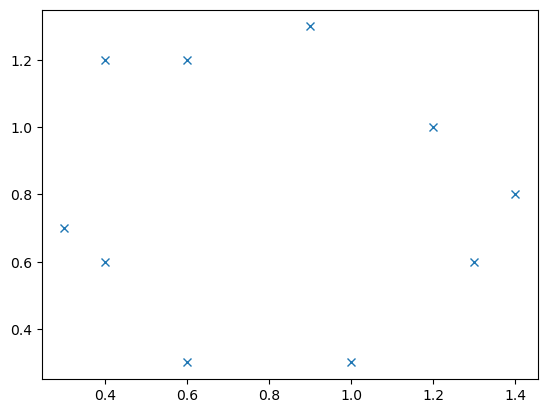

In [18]:
import matplotlib.pyplot as plt
p1=np.array([1.4,1.2,0.9,0.6,0.4,0.3,0.4,0.6,1,1.3])
p2=np.array([0.8,1,1.3,1.2,1.2,0.7,0.6,0.3,0.3,0.6])
plt.plot(p1,p2,"x")
plt.show()

Nous souhaitons approcher $E$ par un cercle $C$ de centre $c = (a, b)$ et de rayon $R$. En notant $\pi(p_i)$ la projection du point $p_i=(x_i,y_i)$ sur le cercle, l'erreur entre $\pi(p_i)$ et $p_i$ est donnée par
$$
e_i = |\|p_i-c \|^2 - R^2| = |(x_i-a)^2 + (y_i-b)^2 - R^2|.
$$
L'erreur totale de l'approximation de l'ensemble $E$ par le cercle $C$ vaut donc
$$
e(a,b,R)^2 = \sum_{i=0}^9 e_i^2 = \sum_{i=0}^9 \big( (x_i - a)^2 + (y_i - b)^2 - R^2 \big)^2
$$
Le cercle optimal $\bar{C}$ est celui dont le centre $\bar{c} = (\bar{a}, \bar{b})$ et le rayon $\bar{R}$ sont ceux qui minimisent l'erreur totale
$$
e(\bar{a}, \bar{b}, \bar{R}) = \min_{(a,b,R) \in \mathbb{R}^2 \times \mathbb{R}_+^*} e(a, b, R).
$$

1. Soit $u = (a, b, R^2 - a^2 - b^2)$. Vérifier que
$$
e(a, b, R)^2 = \sum_{i = 0}^9 \big( 2 x_i u_0 + 2 y_i u_1 + u_2 - x_i^2 - y_i^2 \big)^2 = \| A u - v \|^2,
$$
où
$$
A = \begin{pmatrix} 2 x_0 & 2 y_0 & 1 \\ 2 x_1 & 2 y_1 & 1 \\ \vdots & \vdots & \vdots \\ 2 x_{n-1} & 2 y_{n-1} & 1 \end{pmatrix}, \quad \text{ et } \quad v = \begin{pmatrix} x_0^2 + y_0^2 \\ x_1^2 + y_1^2 \\ \vdots \\ x_{n-1}^2 + y_{n-1}^2 \end{pmatrix}.
$$

Nous commençons par calculer
$$
(x_i - a)^2 + (y_i - b)^2 - R^2 = x_i^2 + y_i^2 - R^2 + a^2 + b^2 - 2 x_i a - 2 y_i b = x_i^2 + y_i^2 - u_2 - 2 x_i u_0 - 2 y_i u_1,
$$
d'où l'expression
$$
e(a, b, R)^2 = \sum_{i = 0}^9 \big( (x_i - a)^2 + (y_i - b)^2 - R^2 \big)^2 = \sum_{i = 0}^9 \big( 2 x_i u_0 + 2 y_i u_1 + u_2 - x_i^2 - y_i^2 \big)^2 = \sum_{i = 0}^9 \big( [A u]_i - v_i \big)^2 = \| A u - v\|^2.
$$

2.a. Déterminer numériquement à l'aide des fonctions `sol_mc` et `np.linalg.lstsq` que la solution de ce problème de minimisation est proche de
$$
u = (0.82, 0.79, -1.02).
$$

In [19]:
A=np.ones((10,3))
A[:,0]=2*np.transpose(p1)
A[:,1]=2*np.transpose(p2)
v=np.transpose(p1**2+p2**2)
u=sol_mc(A,v)
print('u =',u,'\n')
print('u =',np.linalg.lstsq(A,v,rcond=None)[0],'\n')

u = [ 0.82046231  0.78636415 -1.02433159] 

u = [ 0.82046231  0.78636415 -1.02433159] 



b. En déduire le centre et le rayon du cercle optimal $\bar{C}$.

Le cercle optimal $\bar{C}$ est le cercle de centre $(a, b)$ et de rayon $R$ donnés par les valeurs approchées :

In [20]:
print('(a,b) =',(u[0],u[1]),'\n')
R=np.sqrt(u[0]**2+u[1]**2+u[2])
print('R =',R,'\n')

(a,b) = (0.8204623092689581, 0.7863641539512624) 

R = 0.5169094661666632 



3. Représenter graphiquement l'ensemble de points $E$ et le cercle $\bar{C}$.

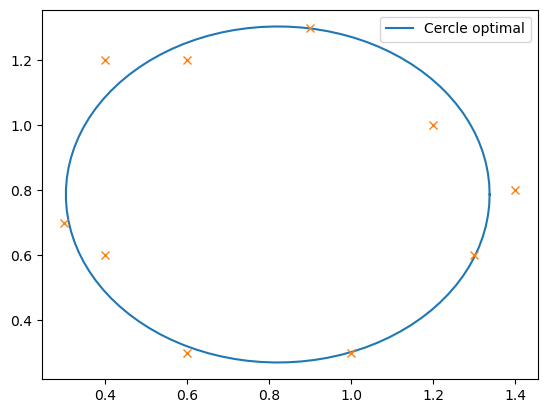

In [21]:
T=np.linspace(0,2*np.pi,100)
X=[]
for t in T:
    X.append(u[0]+R*np.cos(t))
Y=[]
for t in T:
    Y.append(u[1]+R*np.sin(t))
plt.plot(X,Y,label='Cercle optimal')
plt.plot(p1,p2,"x")
plt.legend()
plt.show()

### Exercice 2.

Le produit intérieur brut (en milliers de milliards de dollars, ajustés à l'inflation) de l'Allemagne était par année en 1990 de $1.6$, en 1995 de $2.59$, en 2000 de $1.95$, en 2005 de $2.85$, en 2010 de $3.4$, en 2015 de $3.36$ et en 2020 de $3.88$.

1.a. Calculer numériquement le polynôme d'interpolation de Lagrange du PIB de l'Allemagne associé aux points $(1990, 1995, 2000, 2005, 2010, 2015, 2020)$.

In [22]:
X=np.array([1990,1995,2000,2005,2010,2015,2020])
Y=np.array([1.6,2.59,1.95,2.85,3.4,3.36,3.88])
def PolyLag(x):
    P=0
    for i in range(0,len(X)):
        l=1
        for j in range(0,len(X)):
            if j!=i:
                l=l*(x-X[j])/(X[i]-X[j])
        P=P+Y[i]*l
    return P
# Test de la fonction PolyLag
print('P(1990) =',PolyLag(1990),'\n')
print('P(2010) =',PolyLag(2010),'\n')

P(1990) = 1.6 

P(2010) = 3.4 



b. Représenter graphiquement ce polynôme entre 1990 et 2030.

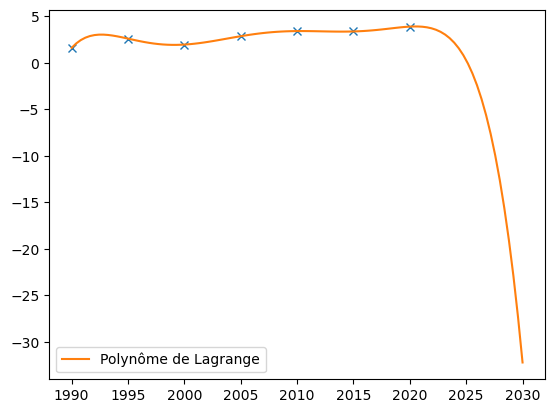

In [23]:
T=np.linspace(1990,2030,100)
U=[]
for t in T:
    U.append(PolyLag(t))
plt.plot(X,Y,'x')
plt.plot(T,U,label='Polynôme de Lagrange')
plt.legend()
plt.show()

c.  Pensez-vous que ce soit une bonne projection de l'évolution du PIB de l'Allemagne ?

L'évolution très dégradée du PIB de l'Allemagne entre 2025 et 2030 ne semble pas très réaliste, de sorte que le polynôme d'interpolation de Lagrange ne paraît pas fournir une projection adéquate de cette évolution.

2.a. Déterminer numériquement le polynôme $P$ de degré $2$ qui approche le PIB de l'Allemagne au sens des moindres carrés pour les points $(1990, 1995, 2000, 2005, 2010, 2015, 2020)$ à l'aide des fonctions `poly_mc` et `numpy.polynomial.polynomial.polyfit`.

In [24]:
Q1=poly_mc(X,Y,2)
R1=np.polynomial.polynomial.polyfit(X,Y,2)
print('Q =',R1,'\n')
# Test de la fonction poly_mc
print(Q1(1990)-R1[0]-R1[1]*(1990)-R1[2]*(1990)**2,'\n')
print(Q1(2000)-R1[0]-R1[1]*2000-R1[2]*(2000)**2,'\n')

Q = [-2.33687857e+02  1.65690476e-01 -2.38095238e-05] 

2.2028245894034626e-10 

-1.31976207740081e-10 



b. Représenter graphiquement ce polynôme entre 1990 et 2030.

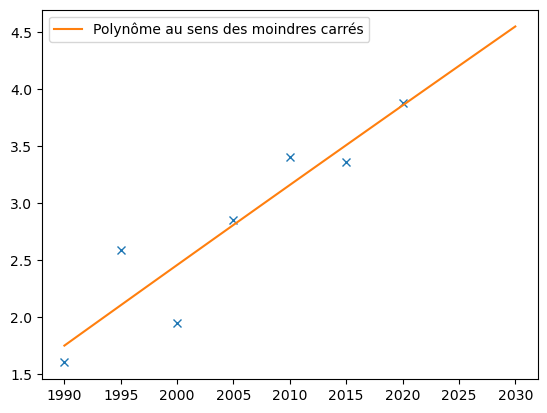

In [25]:
V1=[]
for t in T:
    V1.append(Q1(t))
plt.plot(X,Y,'x')
plt.plot(T,V1,label='Polynôme au sens des moindres carrés')
plt.legend()
plt.show()

c. Pensez-vous que ce soit une bonne projection de l'évolution du PIB de l'Allemagne ?

L'évolution proposée pour le PIB de l'Allemagne entre 2020 et 2030 semble réaliste, compte tenu de l'évolution antérieure de ce PIB.

3. Le produit intérieur brut de l'Inde était par année en 1990 de $0.33$, en 1995 de $0.37$, en 2000 de $0.48$, en 2005 de $0.84$, en 2010 de $1.7$, en 2015 de $2.1$ et en 2020 de $2.7$.

a. Déterminer numériquement le polynôme $Q$ de degré $2$ qui approche le PIB de l'Inde au sens des moindres carrés pour les points $(1990, 1995, 2000, 2005, 2010, 2015, 2020)$.

Q = [ 9.88218000e+03 -9.94078571e+00  2.50000000e-03] 



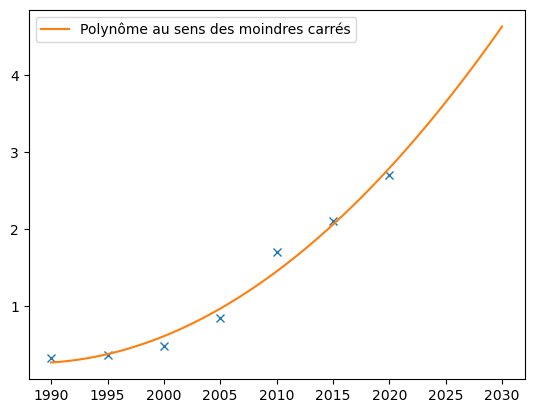

In [26]:
Z=np.array([0.33,0.37,0.48,0.84,1.7,2.1,2.7])
Q2=poly_mc(X,Z,2)
R2=np.polynomial.polynomial.polyfit(X,Z,2)
print('Q =',R2,'\n')
V2=[]
for t in T:
    V2.append(Q2(t))
plt.plot(X,Z,'x')
plt.plot(T,V2,label='Polynôme au sens des moindres carrés')
plt.legend()
plt.show()

b. Nous souhaitons estimer quelle année le PIB de l'Inde dépassera celui de l'Allemagne. Déterminer numériquement la première année $a \geq 2020$ pour laquelle $P(a) \leq Q(a)$.

In [27]:
t=1990
while Q1(t)>Q2(t):
    t=t+1
print('Première année =',t,'\n')

Première année = 2030 



### Exercice 3.

Utiliser la fonction `scipy.optimize` pour trouver le minimum de la fonction
$$
\forall (x,y) \in \mathbb{R}^2, f(x, y) = (2 - x)^2 + 100 (2 y - x^2)^2.
$$

In [28]:
def f(x):
    return (2-x[0])**2+100*(2*x[1]-x[0]**2)**2
print(opt.minimize(f,np.array([1,1])))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 3.200416529350753e-10
        x: [ 2.000e+00  2.000e+00]
      nit: 23
      jac: [-3.894e-07  1.941e-07]
 hess_inv: [[ 4.999e-01  9.998e-01]
            [ 9.998e-01  2.001e+00]]
     nfev: 84
     njev: 28


Le minimum de la fonction $f$ est en effet obtenu pour l'unique minimiseur $(x, y) = (2, 2)$, et la valeur de ce minimum est égale à $0$.

### Exercice 4.

1. Écrire une fonction `points_grad_pasfixe(Df,rho,x0,e0)` qui renvoie les $10$ premiers points $(x_0, \ldots, x_{10})$ de l'algorithme du gradient à pas fixe.

In [29]:
def points_grad_pasfixe(Df,rho,x0,e0):
    x=x0
    y=x0
    e=2*e0
    n=0
    L=np.array([x])
    while n<10 and e>e0:
        y=x-rho*Df(x)
        e=np.linalg.norm(y-x)
        x=y
        n=n+1
        L=np.vstack((L,np.array([x])))
    return L

2. Soit
$$
\forall (x, y) \in \mathbb{R}^2, \, f(x, y) = x^4 + y^6 - x y.
$$
Tracer les $10$ premiers points $(x_0, \ldots, x_9)$ de l'algorithme du gradient à pas fixe, pour un point initial $x_0$ de votre choix.

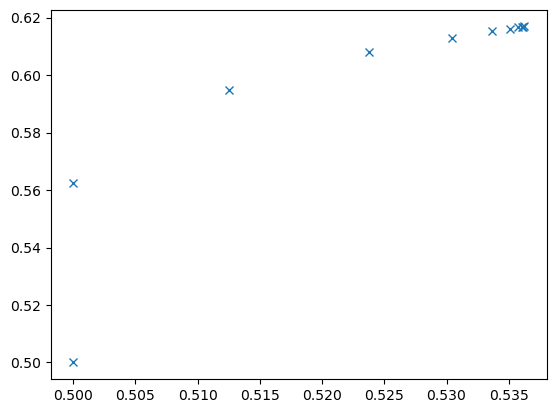

In [30]:
def f(x):
    return x[0]**4+x[1]**6-x[0]*x[1]
def Df(x):
    return np.array([4*x[0]**3-x[1],6*x[1]**5-x[0]])
L=points_grad_pasfixe(Df,0.2,np.array([0.5,0.5]),1.e-15)
plt.plot(L[:,0],L[:,1],'x')
plt.show()

### Exercice 5.

Nous cherchons à comparer les complexités des méthodes numériques du pivot de Gauss et du gradient conjugué pour des systèmes linéaires de grande taille. Considérons ainsi pour $n \geq 1$ le système linéaire
$$
M_n x_n =b_n
$$
avec $M_n \in \mathcal{S}_n^{++}(\mathbb{R})$ et $b_n \in \mathbb{R}^n$ donnés par
$$
M_n = \begin{pmatrix} 2n & 1  & \ldots & (1) \\ 1 & 2n & 1 & \ldots \\ \ldots & \ldots & \ldots & \ldots \\ (1) & \ldots & 1 & 2n \end{pmatrix}, \quad \text{ et } \quad b_n = \begin{pmatrix} 1 \\ 2 \\ \vdots \\ n \end{pmatrix}.
$$
Comparer les temps d'exécution des fonctions `numpy.linalg.solve` et `grad_conj` pour des valeurs grandes de $n$. Que concluez-vous ?

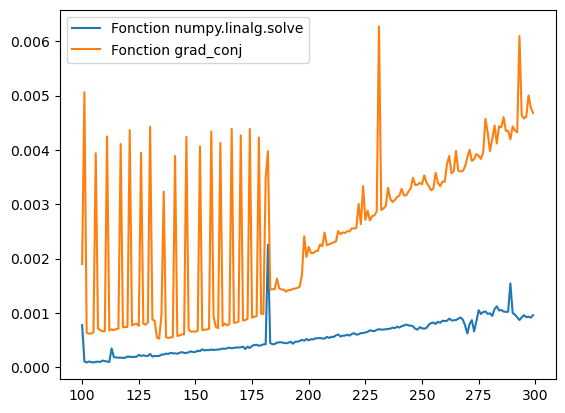

In [31]:
import time as ti
def M(n):
    A=np.ones((n,n))
    A=A+(2*n-1)*np.eye(n)
    return A
def b(n):
    return np.transpose(np.arange(1,n+1,1))
T1=[]
for i in range(100,300):
    t=ti.time()
    np.linalg.solve(M(i),b(i))
    T1.append(ti.time()-t)
T2=[]
for i in range(100,300):
    x0=np.ones((i,1))
    t=ti.time()
    grad_conj(M(i),b(i),x0,i,0.00001)
    T2.append(ti.time()-t)
N=np.arange(100,300,1)
plt.plot(N,T1,label='Fonction numpy.linalg.solve')
plt.plot(N,T2,label='Fonction grad_conj')
plt.legend()
plt.show()

Le graphe précédent montre numériquement que la fonction `numpy.linalg.solve` est plus rapide que la fonction `grad_conj`.

### Exercice 6. 

1. Représenter graphiquement la fonction
$$
f(x_0, x_1) = x_0^2 - x_1^3 +x_0 x_1,
$$
pour $-2 \leq x_0, x_1 \leq 2$ à l'aide de la fonction `pcolormesh` de pyplot.

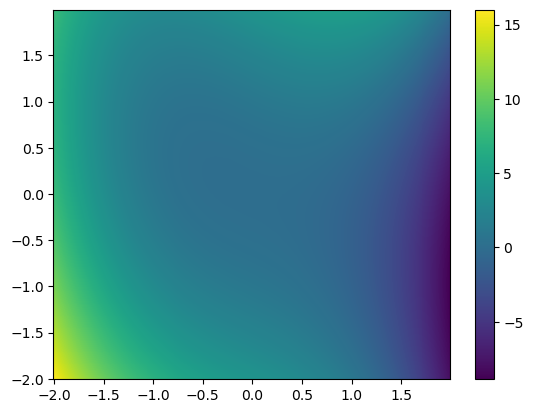

In [32]:
x=np.arange(-2,2,0.01)
y=np.arange(-2,2,0.01)
(X,Y)=np.meshgrid(x,y)
n=len(x)
def f(x,y):
    return x**2-y**3+x*y
Z=np.zeros([n,n])
for i in range(n):
    for j in range(n):
        Z[i,j]=f(x[i],y[j])
plt.pcolormesh(X,Y,Z) 
plt.colorbar()
plt.show()

2. Déterminer grossièrement ou se situe le minimiseur de la fonction $f$ sous la contrainte $x_0^2 + x_1^2 = 1$.

D'après le graphe précédent, le minimiseur de la fonction $f$ sous la contrainte $x_0^2 + x_1^2 = 1$ semble proche du point $(x_0, x_1) = (1, 0)$.

3. En déduire une valeur approchée de ce minimiseur à l'aide de la fonction `Lag_New(Jf,Hf,g,Jg,Hg,x0,q0,eps,N)`.

In [33]:
def Jf(x):
    return np.array([[2*x[0]+x[1],-3*x[1]**2+x[0]]])
def Hf(x):
    return np.array([[2,1],[1,-6*x[1]]])
def g(x):
    return x[0]**2+x[1]**2 - 1
def Jg(x):
    return np.array([[2*x[0],2*x[1]]])
def Hg(x):
    return np.array([[2,0],[0,2]])
print('(x0, x1, q) =',Lag_New(Jf,Hf,g,Jg,Hg,np.array([0.95,0.30]),np.array([-1]),0.1,100),'\n')

(x0, x1, q) = [ 0.9572253   0.28961988 -1.15243152] 



Le couple $(x_0, x_1) = (0.9572253,0.28961988)$ semble donc être un minimiseur approché de la fonction $f$ sous la contrainte $x_0^2 + x_1^2 = 1$.